In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import numpy.linalg as linalg
import time

import cProfile
from matplotlib.colors import LightSource
import timeit

#scipy sims

In [22]:
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
class Triangle:
    #p_3 is the "tip" i.e. point in the middle of element, p_1 and p_2 are the other two verticies. doesnt matter which order
    def __init__(self, p_1, p_2, p_3):
        self.p1=p_1
        self.p2=p_2
        self.p3=p_3
        
    '''area of this triangle'''
    def area(self):
        p1x, p1y, p2x, p2y, p3x, p3y=self.p1.x, self.p1.y,self.p2.x,self.p2.y,self.p3.x,self.p3.y
        return 0.5*np.abs((p1x*p2y+p3x*p1y+p2x*p3y-p1y*p2x-p2y*p3x-p3y*p1x))
    
    '''finds the area given the point p3 as the new vertex'''
    def area_pt(self,p3):
        return 0.5*np.abs((self.p1.x*self.p2.y+p3.x*self.p1.y+self.p2.x*p3.y-self.p1.y*self.p2.x-self.p2.y*p3.x-p3.y*self.p1.x))
    
    def area_pt_signed(self, p3):
        return 0.5*((self.p1.x*self.p2.y+p3.x*self.p1.y+self.p2.x*p3.y-self.p1.y*self.p2.x-self.p2.y*p3.x-p3.y*self.p1.x))
    
    '''defines if the point x y is in the triangle. if not then returns false otherwise true'''
    '''source: https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle'''
    def is_in(self,x, y):
        p1x, p1y, p2x, p2y, p3x, p3y=self.p1.x, self.p1.y,self.p2.x,self.p2.y,self.p3.x,self.p3.y
        Area= 0.5 *(-p2y*p3x + p1y*(-p2x + p3x) + p1x*(p2y - p3y) + p2x*p3y)
        s = 1/(2*Area)*(p1y*p3x - p1x*p3y + (p3y - p1y)*x + (p1x - p3x)*y);
        t = 1/(2*Area)*(p1x*p2y - p1y*p2x + (p1y - p2y)*x + (p2x - p1x)*y);
        return 0<=s and t>=0 and 1-s-t>=0

    def evaluate(self,x,y):
        return self.area_pt(Point(x, y))/self.area() if self.is_in(x,y) else 0
    
class FiniteElement:
    #top left corner
    def __init__(self, x, y, deltaX, deltaY, config):
        self.deltaX=deltaX
        self.deltaY=deltaY
        
        p1=Point(x, y)
        p2=Point(x+deltaX, y)
        p3=Point(x+2*deltaX, y)
        
        p4=Point(x, y-deltaY)
        center=Point(x+deltaX, y-deltaY)
        p5=Point(x+2*deltaX, y-deltaY)
        
        p6=Point(x, y-2*deltaY)
        p7=Point(x+deltaX, y-2*deltaY)
        p8=Point(x+2*deltaX, y-2*deltaY)
        
        self.triangles=[];
        self.center=center
        
        if(config==0):
        
            #top left
            self.tri_tl=Triangle(p2,p4,center)

            #top right
            self.tri_tr=Triangle(p2,p5,center)

            #bottom left
            self.tri_bl=Triangle(p4, p7, center)

            #bottom right
            self.tri_br=Triangle(p5,p7,center)
            self.triangles.append(self.tri_tl)
            self.triangles.append(self.tri_tr)
            self.triangles.append(self.tri_bl)
            self.triangles.append(self.tri_br)

        else:
            self.tri_tl=Triangle(p1,p2,center)

            self.tri_ul=Triangle(p1, p4, center)

            self.tri_ll=Triangle(p4, p6, center)

            #top right
            self.tri_tr=Triangle(p2,p3,center)

            self.tri_ur=Triangle(p3, p5, center)

            self.tri_lr=Triangle(p5, p8, center)


            #bottom left
            self.tri_bl=Triangle(p6, p7, center)

            #bottom right
            self.tri_br=Triangle(p7,p8,center)
            self.triangles.append(self.tri_tl)
            self.triangles.append(self.tri_tr)
            self.triangles.append(self.tri_bl)
            self.triangles.append(self.tri_br)
            self.triangles.append(self.tri_ll)
            self.triangles.append(self.tri_lr)
            self.triangles.append(self.tri_ul)
            self.triangles.append(self.tri_ur)
            
        self.top_left_x=x
        self.top_left_y=y
        
    def in_region_1(self, x, y):
        return x<self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_2(self,x, y):
        return x>=self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_3(self,x, y):
        return x<self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def in_region_4(self,x, y):
        return x>=self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def evaluate(self, x, y):
        thesum=0
        i=0
        tri=self.triangles
        while i<len(tri):
            thesum+=tri[i].evaluate(x, y)
            if(thesum>0):
                return thesum 
            i+=1           
        return thesum
    
class FEM:
    def __init__(self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition):
        self.N=N
        self.M=M
        self.minX=minX
        self.maxX=maxX
        self.minY=minY
        self.maxY=maxY
        self.deltaX=(maxX-minX)/N
        self.deltaY=(maxY-minY)/M
        #function
        self.electronDensity=electronDensity
        self.finiteElements=self.generateFiniteElements();
        self.eps=eps
        self.boundaryCondition=boundaryCondition
        
        #does not generate the boundary finite elements!
    def generateFiniteElements(self):
        finiteElements=np.ndarray(shape=(self.M-1,self.N-1), dtype=FiniteElement)
        for m in range(0,self.M-1):
            #ignore the last row
            for n in range(0,self.N-1):
                config=0 if n%2==0 else 1
                finiteElements[m, n]=FiniteElement(self.minX+n*self.deltaX, self.maxY-m*self.deltaY, self.deltaX, self.deltaY, config)
        return finiteElements
    
    #p1 gives the indicies
    def integrand(self,x, y, p1):
        return (1/self.eps)*self.electronDensity(x,y)*self.finiteElements[p1.x, p1.y].evaluate(x, y)

    def getIntegral(self,p1):
        temp=self.finiteElements[p1.x, p1.y]
        minX=temp.top_left_x
        maxX=minX+self.deltaX*2
        maxY=temp.top_left_y
        minY=maxY-2*self.deltaY
        return integrate.dblquad(self.integrand, minY, maxY, lambda x: minX, lambda x: maxX, args=[p1],epsabs=1e-4)[0]

    def constructBVector(self):
        temp=np.zeros((self.N-1)*(self.M-1))
        for r in range(self.M-1):
            for c in range(self.N-1):
                temp[c+r*(self.N-1)]=self.getIntegral(Point(r,c))
        return temp;
                
    def area(self):
        return self.deltaX*self.deltaY/2
    
    def generateFlagged(self, cols):
        flaggedIndicies1=np.array([self.get1DIndex(0,x, cols) for x in range(self.N+1)]);
        flaggedIndicies2=np.array([self.get1DIndex(y,0, cols) for y in range(1,self.M)]);
        flaggedIndicies3=np.array([self.get1DIndex(self.M,x, cols) for x in range(self.N+1)])
        flaggedIndicies4=np.array([self.get1DIndex(y,self.N, cols) for y in range(1,self.M)]);
        flagged=np.concatenate((flaggedIndicies1,flaggedIndicies2,flaggedIndicies3,flaggedIndicies4))
        return flagged
    
    def constructMatrix(self):
        temp=np.zeros(((self.N+1)*(self.M+1),(self.N+1)*(self.M+1)));
        flagged=self.generateFlagged(self.N+1)
        for m in range(self.M+1):
            for n in range(self.N+1):                
                
                currRow=m*(self.N+1)+n
                index1=self.get1DIndex(m, n-1, self.N+1);
                index2=self.get1DIndex(m+1,n, self.N+1)
                index3=self.get1DIndex(m,n+1, self.N+1)
                index4=self.get1DIndex(m-1,n, self.N+1)
                index5=self.get1DIndex(m,n, self.N+1)
                #print("row, ", currRow)
                if(index1 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index1]=(-1/self.deltaX**2)*2
                if(index2 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index2]=(-1/self.deltaY**2)*2
                if(index3 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index3]=(-1/(self.deltaX)**2)*2
                if(index4 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index4]=(-1/self.deltaY**2)*2
                if(index5 in range((self.N+1)*(self.M+1))):
                    #print("index, ",(currRow,index5))
                    temp[currRow,index5]=4*(1/(self.deltaX)**2+1/self.deltaY**2)
        temp=np.delete(temp, flagged, axis=1)
        temp=np.delete(temp, flagged, axis=0)
        return temp*self.deltaX*self.deltaY

    def solveSystem(self):
        b=self.constructBVector();
        b=b+self.addBoundaryConditions(b, self.M-1, self.N-1)
        M=self.constructMatrix();
        sols=linalg.solve(M, b);
        self.sols=sols
        return self.extractSols(sols);
    
    def getPoint(self,m, n):
        return Point(self.minX+n*self.deltaX, self.maxY-m*self.deltaY)
    
    #from 2d to 1d, assume length is self.N+1
    def get1DIndex(self,m, n, cols):
        return cols*m+n
    
    #in entire matrix
    def get2Dindex(self,i):
        return (i//(self.N+1), i%(self.N+1));
    
    #assumes boundary is removed already
    def getBoundaryIndicies2D(self,arr):
        temp=np.array([]);
        for r in range(np.shape(arr)[0]):
            np.append(temp, (r, 0))
            np.append(temp, (r, np.shape(arr)[0]-1))

        for c in range(1, np.shape(arr)[1]-1):
            np.append(temp, (0, c))
            np.append(temp, (np.shape(arr)[0]-1, c))
        return temp
    
    def getBoundaryIndicies1D(self, rows, cols):        
        y=np.zeros(rows*2, dtype=int)
        x=np.zeros(cols*2,dtype=int)
        county=0;
        countx=0
        for r in range(0, rows):
            y[county]=r*cols
            county+=1
            y[county]=r*cols+cols-1
            county+=1

        for c in range(0, cols):
            x[countx]=c
            countx+=1
            x[countx]=(rows-1)*cols+c
            countx+=1
        
        return (x, y)
    
    #assumes boundary is removed from the index
    #INPUT INDICIES!!!!!!
    def getBoundaryXY(self, arr, rows, cols):
        temp=np.zeros((len(arr),2))
        for i in range(len(arr)):
            r=arr[i]//cols
            c=arr[i]%cols
            if(r==0 and c==0):
                temp[i, 0]=(c+1)*self.deltaX+self.minX
                temp[i,1]=self.maxY 
            if(r==0):
                temp[i, 0]=(c+1)*self.deltaX+self.minX
                temp[i,1]=self.maxY                            
            elif(r==rows-1):
                #print("yay2")
                temp[i,0]=(c+1)*self.deltaX+self.minX
                temp[i,1]=self.minY
            elif(c==0):
                #print("yay3")
                temp[i,0]=self.minX
                temp[i,1]=self.maxY-(r+1)*self.deltaY
            elif(c==cols-1):
                #print("yay4")
                temp[i,0]=self.maxX
                temp[i,1]=self.maxY-(r+1)*self.deltaY
                #print(temp[i,:])
        return temp

    def addBoundaryConditions(self, arr, rows, cols):
        temp=np.zeros(np.shape(arr))
        ind=self.getBoundaryIndicies1D((rows), (cols));
        xy=self.getBoundaryXY(np.concatenate(ind), rows,cols);
        count=0;
        for i in ind[0]:
            temp[i]+=self.boundaryCondition(xy[count,0],xy[count,1])*self.deltaX*self.deltaY*(1/self.deltaX**2)*2;
            count+=1
        for i in ind[1]:
            temp[i]+=self.boundaryCondition(xy[count,0],xy[count,1])*self.deltaX*self.deltaY*(1/self.deltaY**2)*2;
            count+=1
        return temp;
                
    def fillBoundary(self,temp):
        print(np.shape(temp))
        for i in range(np.shape(temp)[0]):
            pt=self.getPoint(i,0)
            pt1=self.getPoint(i, np.shape(temp)[1]-1)
            temp[i,0]=self.boundaryCondition(pt.x, pt.y)
            temp[i,np.shape(temp)[1]-1]=self.boundaryCondition(pt1.x, pt1.y)
        for i in range(1, np.shape(temp)[1]-1):
            pt=self.getPoint(0,i)
            pt1=self.getPoint(np.shape(temp)[0]-1, i)
            temp[0,i]=self.boundaryCondition(pt.x, pt.y)
            temp[np.shape(temp)[0]-1, i]=self.boundaryCondition(pt1.x, pt1.y)
        return temp
    
    def turnIntoGraphable(self, sols):
        xy=np.zeros(((self.M+1)*(self.N+1),2));
        for m in range(self.M+1):
            for n in range(self.N+1):
                xy[m*(self.N+1)+n,0]=n*self.deltaX+self.minX
                xy[m*(self.N+1)+n,1]=self.maxY-m*self.deltaY
        return (xy, sols.flatten())
    
    def getXYCoords(self):
        x=np.zeros(((self.M+1),(self.N+1)));
        y=np.zeros(((self.M+1),(self.N+1)));
        for m in range(self.M+1):
            for n in range(self.N+1):
                x[m,n]=n*self.deltaX+self.minX
                y[m,n]=self.maxY-m*self.deltaY
        return (x,y)
    
    def extractSols(self,sols):
        temp=np.zeros((self.M+1, self.N+1));
        for i in range(len(sols)):
            row=i//(self.N-1)+1
            col=i%(self.N-1)+1
            temp[row, col]=sols[i]
        temp=self.fillBoundary(temp);
        return temp;
    
    def getGraphableArrays(self):
        sols=self.solveSystem()
        return self.turnIntoGraphable(sols)
    
    def graphResults(self):
        plt.clf();
        sols=self.solveSystem()
        graphData=self.turnIntoGraphable(sols)
        xs = graphData[0][:,0]
        ys = graphData[0][:,1]

        function=graphData[1]

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (self.M+1, self.N+1)

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=((self.M+1)*(self.N+1),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(xs,ys,function, facecolors=new_img);
        plt.savefig("3dplot, N: "+str(self.N)+", M: "+str(self.M)+".png")
        
    def graphSlice(self, n):
        plt.clf();
        fsols=finiteElement.extractSols(self.sols)
        xy=finiteElement.getXYCoords()
        y=xy[1][(n),:][0]
        ys=(fsols[(M-1)*N+c] for c in range(N+1))
        theys=[Test.erf_solution(x, y) for x in xy[0][(M-1),:]]
        plt.scatter(xy[0][n,:], fsols[n,:],s=10)
        plt.scatter(xy[0][n,:],theys, s=10,c="orange")
        plt.savefig("2dplot, N: "+str(self.N)+", M: "+str(self.M)+", y: "+str(y)+".png")
        
    def computeError(self, func):
        xs = np.linspace(startX, endX,num=self.N+1,axis=0)
        ys = np.linspace(startY, endY,num=self.M+1,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])
        function=np.array([func(p[0], p[1]) for p in output])
        pass
        
class Test:
    def __init__(self):
        pass
    
    @staticmethod
    def plot(startX, endX, startY, endY,num, func):
        xs = np.linspace(startX, endX,num=num,axis=0)
        ys = np.linspace(startY, endY,num=num,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])
        function=np.array([func(p[0], p[1]) for p in output])

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (function.size//len(xs), len(xs))

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=(len(xs)*len(ys),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(output[:,0],output[:,1],function, facecolors=new_img);
        
    @staticmethod
    def erf_solution(x, y):
        return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))
    @staticmethod    
    def createArrayOfValues(func, minX, minY, maxX, maxY, deltaX, deltaY):
        cols=int((maxX-minX)//deltaX)
        rows=int((maxY-minY)//deltaY)
        temp=np.zeros((rows, cols))
        for r in range(rows):
            for c in range(cols):
                temp[r, c]=func(minX+deltaX*c, maxY-deltaY*r)
        return temp
    @staticmethod    
    def computeGradientMatrix(func, minX, minY, maxX, maxY, deltaX, deltaY):
        values=Test.createArrayOfValues(func, minX, minY, maxX, maxY, deltaX, deltaY)
        return np.gradient(values, deltaX)
        

In [23]:
eps=1

minX=-5
maxX=5
minY=-5
maxY=5

N=100
M=100
sigma=1
a=1


def boundaryCondition(x, y):
    return 1/(4*np.pi*eps)*1/np.sqrt(x**2+y**2)

def electronDensity(x, y):
    return (1/np.sqrt(2*np.pi*sigma**2))**3*(np.exp((-(x**2+y**2))/(2*sigma**2)))

def electronDensity_hydrogen1s(x,y):
    return (1/(np.pi*a**3))*(np.exp(-2*np.sqrt(x**2+y**2)/a)) if r>0 else (1/(np.pi*a**3))*(np.exp(2*np.sqrt(x**2+y**2)/a))

#self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition
finiteElement=FEM(N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition)

/Users/Jessica/opt/miniconda3/envs/csc294/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(101, 101)


<Figure size 432x288 with 0 Axes>

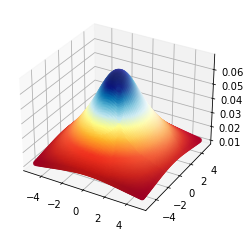

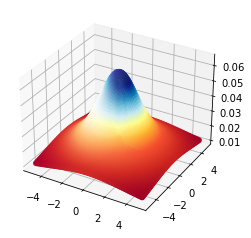

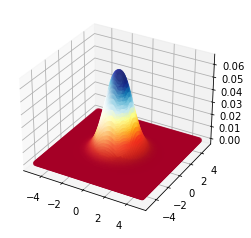

In [24]:
finiteElement.graphResults()
Test.plot(minX,maxX,minY,maxY,100,Test.erf_solution)
Test.plot(minX,maxX,minY,maxY,100,electronDensity)

(101, 101)


/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_76888/1890524828.py:427: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))
/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_76888/1890524828.py:427: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))


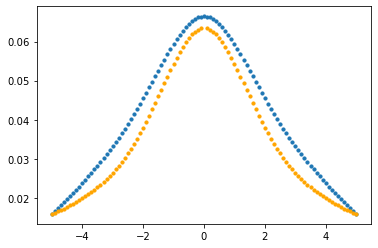

In [25]:
finiteElement.graphSlice(M//2)

(101, 101)


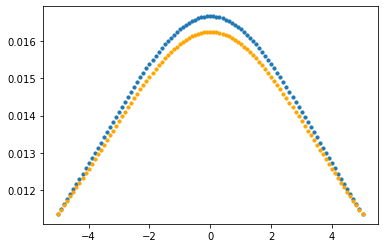

In [26]:
finiteElement.graphSlice(M-1)

In [1093]:
fsols[0,:]

array([0.01125395, 0.01148124, 0.01171271, 0.01194798, 0.01218657,
       0.01242791, 0.01267131, 0.01291597, 0.01316094, 0.01340517,
       0.01364742, 0.01388636, 0.01412049, 0.01434819, 0.01456769,
       0.01477717, 0.01497469, 0.0151583 , 0.01532605, 0.01547602,
       0.01560643, 0.01571561, 0.01580213, 0.01586481, 0.01590278,
       0.01591549, 0.01590278, 0.01586481, 0.01580213, 0.01571561,
       0.01560643, 0.01547602, 0.01532605, 0.0151583 , 0.01497469,
       0.01477717, 0.01456769, 0.01434819, 0.01412049, 0.01388636,
       0.01364742, 0.01340517, 0.01316094, 0.01291597, 0.01267131,
       0.01242791, 0.01218657, 0.01194798, 0.01171271, 0.01148124,
       0.01125395])

In [1126]:
cProfile.run('finiteElement.constructBVector()')

         398790508 function calls (397479352 primitive calls) in 400.977 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 24510003   81.790    0.000   81.790    0.000 1213147394.py:17(electronDensity)
 24510003   51.583    0.000  267.550    0.000 870614964.py:120(evaluate)
 14793831   21.558    0.000   21.558    0.000 870614964.py:14(area)
 24510003   29.154    0.000  378.494    0.000 870614964.py:158(integrand)
     7301    0.154    0.000  400.980    0.055 870614964.py:161(getIntegral)
   327789    0.042    0.000    0.042    0.000 870614964.py:167(<lambda>)
        1    0.046    0.046  401.030  401.030 870614964.py:169(constructBVector)
 14793831   27.597    0.000   27.597    0.000 870614964.py:19(area_pt)
 14801132    3.997    0.000    3.997    0.000 870614964.py:2(__init__)
 88785560  113.658    0.000  113.658    0.000 870614964.py:27(is_in)
 88785560   41.479    0.000  208.286    0.000 870614964.py:34(evaluate)
        

In [328]:
b

array([1.55151627e-08, 2.03005076e-06, 4.15905038e-06, 5.37416210e-05,
       2.68805763e-05, 5.37416210e-05, 4.15905038e-06, 2.03005076e-06,
       1.55151627e-08, 4.04959042e-07, 3.95469260e-05, 1.02286066e-04,
       1.07639908e-03, 6.47880260e-04, 1.07639908e-03, 1.02286066e-04,
       3.95469260e-05, 4.04959042e-07, 4.15909076e-06, 3.16266299e-04,
       1.00633186e-03, 8.84764089e-03, 6.26648911e-03, 8.84764089e-03,
       1.00633186e-03, 3.16266299e-04, 4.15909076e-06, 1.68442203e-05,
       1.07639927e-03, 3.96279664e-03, 3.07609608e-02, 2.43921457e-02,
       3.07609608e-02, 3.96279664e-03, 1.07639927e-03, 1.68442203e-05,
       2.68805845e-05, 1.61157981e-03, 6.26648908e-03, 4.64351063e-02,
       3.84252238e-02, 4.64351063e-02, 6.26648908e-03, 1.61157981e-03,
       2.68805845e-05, 1.68544646e-05, 1.07639927e-03, 3.96684320e-03,
       3.07609608e-02, 2.44218537e-02, 3.07609608e-02, 3.96684320e-03,
       1.07639927e-03, 1.68544646e-05, 4.15909076e-06, 3.16266299e-04,
      

In [322]:
b.shape

(81,)

In [569]:
finiteElement.M-1

9

In [567]:
te=finiteElement.getBoundaryIndicies1D(finiteElement.M-1,finiteElement.N-1)

In [568]:
te

(array([ 1, 73,  2, 74,  3, 75,  4, 76,  5, 77,  6, 78,  7, 79]),
 array([ 9, 17, 18, 26, 27, 35, 36, 44, 45, 53, 54, 62, 63, 71]))

In [305]:
finiteElement.getBoundaryXY(te, finiteElement.M-1,finiteElement.N-1).shape

rows:  8
cols:,  8
(0, 0)
(0, 8)
(1, 0)
(1, 8)
(2, 0)
(2, 8)
(3, 0)
(3, 8)
(4, 0)
(4, 8)
(5, 0)
(5, 8)
(6, 0)
(6, 8)
(7, 0)
(7, 8)
(8, 0)
(8, 8)
(0, 1)
(8, 1)
(0, 2)
(8, 2)
(0, 3)
(8, 3)
(0, 4)
(8, 4)
(0, 5)
(8, 5)
(0, 6)
(8, 6)
(0, 7)
(8, 7)


(32, 2)

In [159]:
Test.erf_solution(5,-5)

0.011253953951946524

In [457]:
finiteElement.getIntegral(Point(5, 5))

0.039283270476846995

In [458]:
cProfile.run('finiteElement.getIntegral(Point(5, 5))')

         60288 function calls (60204 primitive calls) in 0.087 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3759    0.013    0.000    0.013    0.000 2671086426.py:18(electronDensity)
     3759    0.008    0.000    0.065    0.000 2815419501.py:127(evaluate)
     3759    0.006    0.000    0.006    0.000 2815419501.py:14(area)
     3759    0.004    0.000    0.083    0.000 2815419501.py:165(integrand)
        1    0.000    0.000    0.087    0.087 2815419501.py:168(getIntegral)
       21    0.000    0.000    0.000    0.000 2815419501.py:174(<lambda>)
     3759    0.006    0.000    0.006    0.000 2815419501.py:19(area_pt)
     3760    0.001    0.000    0.001    0.000 2815419501.py:2(__init__)
    12471    0.034    0.000    0.034    0.000 2815419501.py:34(is_in)
    12471    0.009    0.000    0.056    0.000 2815419501.py:41(evaluate)
        1    0.000    0.000    0.087    0.087 <string>:1(<module>)
     22/1    0.000    0

In [119]:
cProfile.run('finiteElement.getIntegral(Point(6, 5))')

         156186 function calls (156102 primitive calls) in 0.191 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10815    0.017    0.000    0.137    0.000 318662846.py:120(evaluate)
    10804    0.016    0.000    0.016    0.000 318662846.py:14(area)
    10815    0.012    0.000    0.184    0.000 318662846.py:155(integrand)
        1    0.000    0.000    0.191    0.191 318662846.py:158(getIntegral)
       21    0.000    0.000    0.000    0.000 318662846.py:164(<lambda>)
    10804    0.019    0.000    0.019    0.000 318662846.py:19(area_pt)
    10805    0.003    0.000    0.003    0.000 318662846.py:2(__init__)
    45504    0.058    0.000    0.058    0.000 318662846.py:27(is_in)
    45504    0.024    0.000    0.119    0.000 318662846.py:34(evaluate)
    10815    0.035    0.000    0.035    0.000 440238750.py:17(electronDensity)
        1    0.000    0.000    0.191    0.191 <string>:1(<module>)
     22/1    0.000    0.000    

In [118]:
finiteElement.getIntegral(Point(6, 5))

0.00010224424095003971

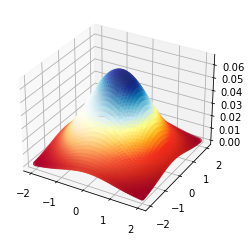

In [469]:
Test.plot(-2, 2, -2, 2, 50, electronDensity)

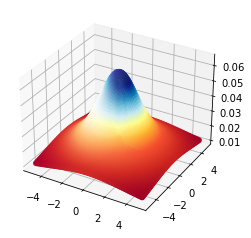

In [447]:
rgb.shape

(10, 10, 4)

In [457]:
new_img = rgb.transpose((2, 0, 1))
# Dimensions: [3, m, n]
new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])


In [458]:
new_img

array([[0.68481796, 0.        , 0.16496235, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.68481796, 0.        , 0.16496235, 1.        ],
       [0.73246635, 0.04995992, 0.16913513, 1.        ],
       [0.84716872, 0.17687766, 0.19161746, 1.        ],
       [0.94752375, 0.45880295, 0.30754923, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.94752375, 0.45880295,

In [763]:
fin=FiniteElement(0, 0, 1, 1, 1)

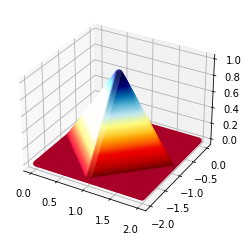

In [776]:
fin=FiniteElement(0, 0, 1, 1, 0)
Test.plot(0, 2, -2, 0,100,fin.evaluate)

In [784]:
fin.evaluate(0.6,-1.5)

0.09999999999999987

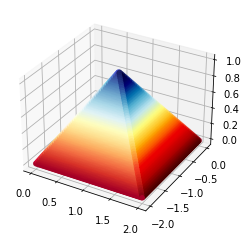

In [764]:
Test.plot(0, 2, -2, 0,100,fin.evaluate)

In [775]:
fin.evaluate(0.55,-1.5)

0.5

In [101]:
fin.evaluate(1,-1)

1

In [83]:
fin.evaluate(1,-1)

4.0

In [26]:
integrate.dblquad(fin.evaluate, -2, 0,lambda x: 0, lambda x: 2)[0]

0.6666666498972109

In [573]:
fin.evaluate(1.8,-1.8)

0

In [607]:
integrate.dblquad(electronDensity, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8)[0]

0.090866060540632

In [ ]:
Test.plot(0, 0.4, -0.4, 0,100,finiteElement.finiteElements[5, 5].evaluate)
Test.plot(0, 0.4, -0.4, 0,100,electronDensity)

In [13]:
def lol(x, y):
    return electronDensity(x, y)*fin.evaluate(x, y)

In [636]:
test=[(integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8*10**i)[0]) for i in range(0, 7)]

In [637]:
test

[0.0016191353028300304,
 0.0016191286222514505,
 0.0016191289772780834,
 0.00161919315870105,
 0.0016219522329523855,
 0.001613626045322107,
 0.0015999807360674192]

In [640]:
1e-8*10**4

0.0001

In [29]:
cProfile.run('integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2)[0]')

         473690 function calls (473438 primitive calls) in 0.569 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    38073    0.113    0.000    0.113    0.000 1226877424.py:16(electronDensity)
    38073    0.027    0.000    0.546    0.000 2234026894.py:1(lol)
    17993    0.071    0.000    0.071    0.000 74039619.py:14(area)
    17993    0.031    0.000    0.031    0.000 74039619.py:18(area_pt)
    17993    0.005    0.000    0.005    0.000 74039619.py:2(__init__)
   152292    0.192    0.000    0.192    0.000 74039619.py:23(is_in)
   152292    0.061    0.000    0.361    0.000 74039619.py:35(evaluate)
    38073    0.045    0.000    0.406    0.000 74039619.py:84(evaluate)
       63    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.569    0.569 <string>:1(<module>)
     64/1    0.000    0.000    0.568    0.568 quadpack.py:445(_quad)
     64/1    0.000    0.000    0.568    0.568 quadpack.py

In [622]:
integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-4)[0]

0.0016219522329523855

In [36]:
def integrand(x, y):
    return (1/finiteElement.eps)*finiteElement.electronDensity(x,y)*finiteElement.finiteElements[5, 5].evaluate(x, y)

In [40]:
integrate.dblquad(integrand, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-5)[0]

0.00161919315870105

In [ ]:
0.0016191281781632982